<a href="https://colab.research.google.com/github/augustosma/antenas/blob/main/PyNEC_dipolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
 #%pip install necpp
 !pip install PyNEC==1.7.3.4

     |████████████████████████████████| 225kB 5.6MB/s 
  Created wheel for PyNEC: filename=PyNEC-1.7.3.4-cp36-cp36m-linux_x86_64.whl size=1490402 sha256=b00b9206e767dd12f41987bb93cd6824eb194bf95e69d106c2193ae8a25beecd
  Stored in directory: /root/.cache/pip/wheels/df/64/17/0e11fec68fc61babe8fb5de5316e0c911e4f41ec694f4c0bcc
Successfully built PyNEC


In [3]:
from PyNEC import *

import math
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

def geometry_monopole(freq, base, length):
    conductivity = 1.45e6 # Stainless steel
    ground_conductivity = 0.002
    ground_dielectric = 10

    wavelength = 3e8/(1e6*freq)
    n_seg = int(math.ceil(50*length/wavelength))

    #nec = context_clean(nec_context())
    nec = nec_context()

    geo = nec.get_geometry()
    geo.wire(1, n_seg, 0, 0, base, 0, 0, base+length, 0.002, 1.0, 1.0)
    nec.geometry_complete(1)

    nec.ld_card(5, 0, 0, 0, conductivity, 0.0, 0.0)
    #nec.gn_card(0, 0, ground_dielectric, ground_conductivity, 0, 0, 0, 0)
    nec.gn_card(-1, 0, 0, 0, 0, 0, 0, 0) #no ground, free space
    nec.fr_card(0, 1, freq, 0)

    # Voltage excitation one third of the way along the wire
    nec.ex_card(0, 0, int(n_seg/3), 0, 1.0, 0, 0, 0, 0, 0)

    return nec
    
    
def geometry_dipole(freq, base, length):
    conductivity = 1.45e6 # Stainless steel
    ground_conductivity = 0.002
    ground_dielectric = 10

    wavelength = 3e8/(1e6*freq)
    n_seg = int(math.ceil(50*length/wavelength))

    nec = nec_context()

    geo = nec.get_geometry()
    geo.wire(1, n_seg, -length/2, 0, base, length/2, 0, base, 0.002, 1.0, 1.0)
    nec.geometry_complete(1)

    nec.ld_card(5, 0, 0, 0, conductivity, 0.0, 0.0)
    #nec.gn_card(0, 0, ground_dielectric, ground_conductivity, 0, 0, 0, 0)
    nec.gn_card(-1, 0, 0, 0, 0, 0, 0, 0) #no ground, free space
    nec.fr_card(0, 1, freq, 0)

    # Voltage excitation one third of the way along the wire
    nec.ex_card(0, 0, int(n_seg/2), 0, 1.0, 0, 0, 0, 0, 0)

    return nec    
  

def plot_rd(nec):
    rp = nec.get_radiation_pattern(0)
    # Gains are in decibels
    gains_db = rp.get_gain()
    gains = 10.0**(gains_db / 10.0)
    thetas = rp.get_theta_angles() * 3.1415 / 180.0
    phis = rp.get_phi_angles() * 3.1415 / 180.0
    # Plot stuff

    fig = plt.figure()	
    ax = fig.add_subplot(111, polar=True)
    #ax.plot(thetas, gains[:,0], color='r', linewidth=3)
    ax.plot(phis, gains[90,:], color='r', linewidth=3)
    ax.grid(True)

    ax.set_title("Gain", va='bottom')
    plt.savefig('RadiationPattern.png')
    return fig


 
def plot_3d(nec):#,thetas,phis,gains):
    rp = nec.get_radiation_pattern(0)
    # Gains are in decibels
    gains_db = rp.get_gain()
    gains = 10.0**(gains_db / 10.0)
    thetas = rp.get_theta_angles() * 3.1415 / 180.0
    phis = rp.get_phi_angles() * 3.1415 / 180.0
        
    THETA, PHI = np.meshgrid(thetas, phis)
    R = gains    
    X = R * np.sin(PHI) * np.cos(THETA)
    Y = R * np.sin(PHI) * np.sin(THETA)
    Z = R * np.cos(PHI)
    
    v = gains
    v_max = np.max(v)
    my_cm = cm.jet(v/v_max)
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1, projection='3d')
    ax.grid(True)
    ax.axis('on')    
    ax.plot_surface(X,Y,Z, facecolors = my_cm )#cmap=plt.get_cmap('jet'))
    #ax3.plot_surface(..., facecolors=cmap(R))
    #ax3.plot_surface(X,Y,Z,rstride=2, cstride=2,color='w',linewidth=0.6,shade=False)
    #fig.colorbar(surf, shrink=0.5, aspect=5)
    
    m = cm.ScalarMappable(cmap=cm.jet)
    m.set_array(R)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    fig.colorbar(m, shrink=0.8)
    ax.view_init(azim=300, elev = 30)
    return fig
    
def plot_directivity(nec):
    
    rp = nec.get_radiation_pattern(0)
    # Gains are in decibels
    gains_db = rp.get_gain()
    gains = 10.0**(gains_db / 10.0)
    
    print(gains.shape())
    #thetas = rp.get_theta_angles() * 3.1415 / 180.0
    #phis = rp.get_phi_angles() * 3.1415 / 180.0
        
	
    #plt.plot(freq,Dir)
    #plt.xlabel("Frequency")
    #plt.ylabel("Directivity at Theta =", Theta, "and Phi = ", Phi)
    #plt.title("Directivity vs frequency ")
    #plt.grid(True)
    #plt.show()
    #plt.savefig("Directivity.png")

    





Impedance is [721.36919502-826.02152297j]


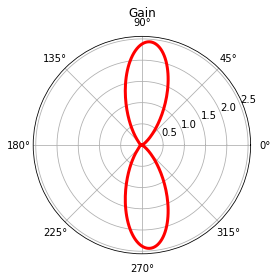

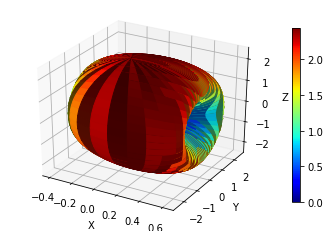

In [4]:
nec = geometry_dipole(freq=300.0, base=0.5, length=1.0)


nec.rp_card(calc_mode=0, n_theta=361, n_phi=361, output_format=0, normalization=0, D=0, A=0, theta0=0, delta_theta=1, phi0=0, delta_phi=1, radial_distance=0, gain_norm=0)
#nec.rp_card(calc_mode=0, n_theta=30, n_phi=30, output_format=0, normalization=0, D=0, A=0, theta0=30, delta_theta=0, phi0=0, delta_phi=5, radial_distance=0, gain_norm=5)
nec.xq_card(0) # Execute simulation

ipt = nec.get_input_parameters(0)
z = ipt.get_impedance()
print("Impedance is {}".format(z))

f1 = plot_rd(nec)
f2 = plot_3d(nec)
plt.show()


#nec = geometry_dipole_fs(f_init=150.0,f_final=300.0,f_step=100.0, base=0.5, length=1.0)
#nec.rp_card(calc_mode=0, n_theta=1, n_phi=1, output_format=0, normalization=0, D=1, A=0, theta0=0, delta_theta=0, phi0=0, delta_phi=0, radial_distance=0, gain_norm=0)
#nec.xq_card(0) # Execute simulation

#plot_directivity(nec)